### requirements and dataset

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.svm import SVC

df = pd.read_csv('dataset/loan_prediction.csv')
df.head(2)

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N


### Data Cleaning

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 67.2+ KB


In [3]:
df = df.drop('Loan_ID', axis=1)

In [4]:
print(df.isnull().sum())
print(df.shape)

Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64
(614, 12)


In [5]:
df.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,614.000000,614.000000,592.000000,600.00000,564.000000
mean,5403.459283,1621.245798,146.412162,342.00000,0.842199
std,6109.041673,2926.248369,85.587325,65.12041,0.364878
min,150.000000,0.000000,9.000000,12.00000,0.000000
25%,2877.500000,0.000000,100.000000,360.00000,1.000000
50%,3812.500000,1188.500000,128.000000,360.00000,1.000000
75%,5795.000000,2297.250000,168.000000,360.00000,1.000000
max,81000.000000,41667.000000,700.000000,480.00000,1.000000


In [6]:
print(df.Gender.mode())
print(df.Married.mode())
print(df.Dependents.mode())
print(df.Self_Employed.mode())

0    Male
Name: Gender, dtype: object
0    Yes
Name: Married, dtype: object
0    0
Name: Dependents, dtype: object
0    No
Name: Self_Employed, dtype: object


In [7]:
# Fill missing values in categorical columns with mode
df['Gender'].fillna(df['Gender'].mode()[0], inplace=True)
df['Married'].fillna(df['Married'].mode()[0], inplace=True)
df['Dependents'].fillna(df['Dependents'].mode()[0], inplace=True)
df['Self_Employed'].fillna(df['Self_Employed'].mode()[0], inplace=True)

In [8]:
# Fill missing values in LoanAmount with the median
df['LoanAmount'].fillna(df['LoanAmount'].median(), inplace=True)

# Fill missing values in Loan_Amount_Term with the mode
df['Loan_Amount_Term'].fillna(df['Loan_Amount_Term'].mode()[0], inplace=True)

# Fill missing values in Credit_History with the mode
df['Credit_History'].fillna(df['Credit_History'].mode()[0], inplace=True)

In [9]:
print(df.isnull().sum())
print(df.shape)

Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
dtype: int64
(614, 12)


### exploratory analisys

In [20]:
# crosstab and value_count functions
def value_counts_summary(df, columns):
    """
    Receives a DataFrame and a list of columns to perform value_counts and 
    value_counts(normalize=True). Returns a DataFrame with absolute and 
    normalized counts, aligning unique variables across different columns.

    Args:
    - df: pd.DataFrame, the input DataFrame.
    - columns: list of str, names of the columns for performing value_counts.

    Returns:
    - pd.DataFrame, a DataFrame containing the count results.
    """
    results = []

    for col in columns:
        # Absolute value counts
        abs_counts = df[col].value_counts().reset_index()
        abs_counts.columns = ['Value', 'Absolute Count']
        
        # Normalized value counts
        norm_counts = df[col].value_counts(normalize=True * 100).map('{:.2f}%'.format).reset_index()
        norm_counts.columns = ['Value', 'Normalized Count']
        
        # Merge absolute and normalized counts
        summary = pd.merge(abs_counts, norm_counts, on='Value', how='outer')
        summary['Column'] = col  # Add the name of the original column
        
        # Add normalized count as 0 for missing values
        summary['Normalized Count'].fillna(0, inplace=True)
        
        results.append(summary)

    # Concatenate all resulting DataFrames into a single DataFrame
    final_df = pd.concat(results, ignore_index=True)

    return final_df

# crosstab function
def print_comparisons_with_loan_status(df, columns):
    """
    Computes and prints cross-tabulations of 'Loan_Status' against each of the other columns in the DataFrame.

    Args:
    - df: pd.DataFrame, the input DataFrame.
    - columns: list of str, names of the columns to compare with 'Loan_Status'.
    """
    for col in columns:
        if col != 'Loan_Status':
            # Compute cross-tabulation of Loan_Status against each column
            crosstab = pd.crosstab(df['Loan_Status'], df[col], normalize='index') * 100
            crosstab = crosstab.applymap('{:.2f}%'.format)
            
            # Print the cross-tabulation
            print(f"\nCross-Tabulation: Loan_Status vs {col}")
            print(crosstab)
            print("="*40)




In [21]:
columns_to_analyze = ['Gender', 'Married', 'Education', 'Self_Employed', 'Loan_Status']
result_df = value_counts_summary(df, columns_to_analyze)

# Reorder the columns
result_df = result_df[['Column', 'Value', 'Absolute Count', 'Normalized Count']]

print(result_df)


          Column         Value  Absolute Count Normalized Count
0         Gender          Male             502            0.82%
1         Gender        Female             112            0.18%
2        Married           Yes             401            0.65%
3        Married            No             213            0.35%
4      Education      Graduate             480            0.78%
5      Education  Not Graduate             134            0.22%
6  Self_Employed            No             532            0.87%
7  Self_Employed           Yes              82            0.13%
8    Loan_Status             Y             422            0.69%
9    Loan_Status             N             192            0.31%


In [23]:
columns_to_analyze_2 = ['Gender', 'Married', 'Education', 'Self_Employed']
print_comparisons_with_loan_status(df, columns_to_analyze_2)



Cross-Tabulation: Loan_Status vs Gender
Gender       Female    Male
Loan_Status                
N            19.27%  80.73%
Y            17.77%  82.23%

Cross-Tabulation: Loan_Status vs Married
Married          No     Yes
Loan_Status                
N            41.15%  58.85%
Y            31.75%  68.25%

Cross-Tabulation: Loan_Status vs Education
Education   Graduate Not Graduate
Loan_Status                      
N             72.92%       27.08%
Y             80.57%       19.43%

Cross-Tabulation: Loan_Status vs Self_Employed
Self_Employed      No     Yes
Loan_Status                  
N              86.46%  13.54%
Y              86.73%  13.27%


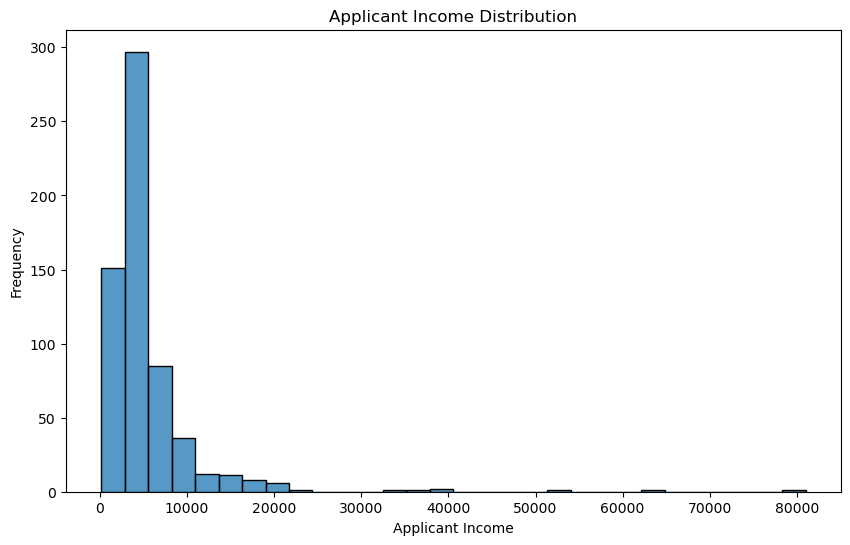

In [26]:
plt.figure(figsize=(10, 6))
sns.histplot(df['ApplicantIncome'], bins=30, kde=False)

plt.title('Applicant Income Distribution')
plt.xlabel('Applicant Income')
plt.ylabel('Frequency')
plt.show()


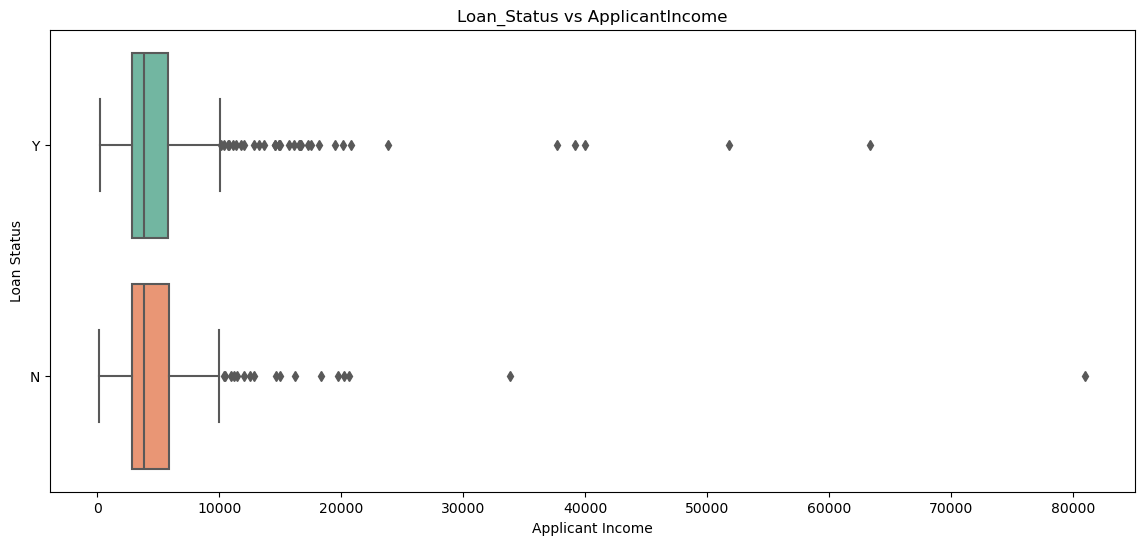

In [27]:
plt.figure(figsize=(14, 6))
sns.boxplot(x='ApplicantIncome', y='Loan_Status', data=df, palette='Set2')

plt.title('Loan_Status vs ApplicantIncome')
plt.xlabel('Applicant Income')
plt.ylabel('Loan Status')
plt.show()

In [30]:
# Calculate the IQR
Q1 = df['ApplicantIncome'].quantile(0.25)
Q3 = df['ApplicantIncome'].quantile(0.75)
IQR = Q3 - Q1

# Define the lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Remove outliers
df = df[(df['ApplicantIncome'] >= lower_bound) & (df['ApplicantIncome'] <= upper_bound)]

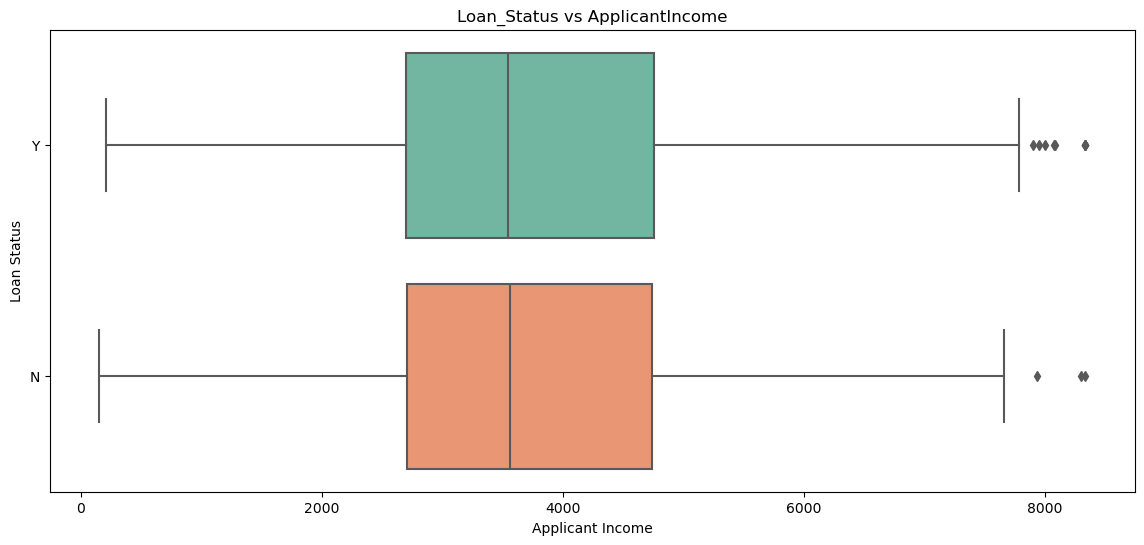

In [31]:
plt.figure(figsize=(14, 6))
sns.boxplot(x='ApplicantIncome', y='Loan_Status', data=df, palette='Set2')

plt.title('Loan_Status vs ApplicantIncome')
plt.xlabel('Applicant Income')
plt.ylabel('Loan Status')
plt.show()

In [32]:
# Calculate the IQR
Q1 = df['CoapplicantIncome'].quantile(0.25)
Q3 = df['CoapplicantIncome'].quantile(0.75)
IQR = Q3 - Q1

# Define the lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Remove outliers
df = df[(df['CoapplicantIncome'] >= lower_bound) & (df['CoapplicantIncome'] <= upper_bound)]

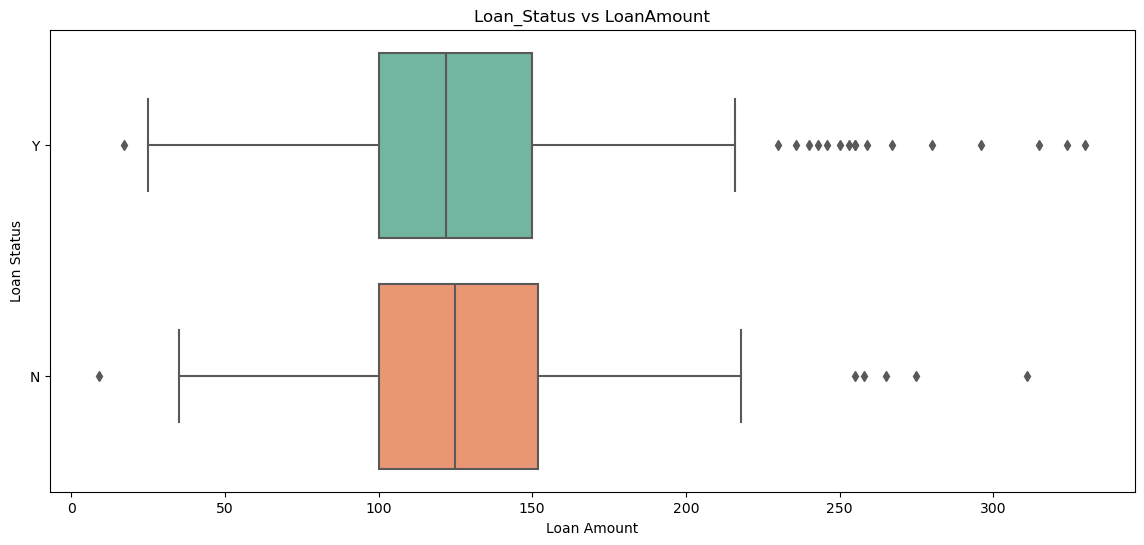

In [33]:
# Assuming `df` is your DataFrame and it contains the 'Loan_Status' and 'LoanAmount' columns
plt.figure(figsize=(14, 6))
sns.boxplot(x='LoanAmount', y='Loan_Status', data=df, palette='Set2')

plt.title('Loan_Status vs LoanAmount')
plt.xlabel('Loan Amount')
plt.ylabel('Loan Status')
plt.show()

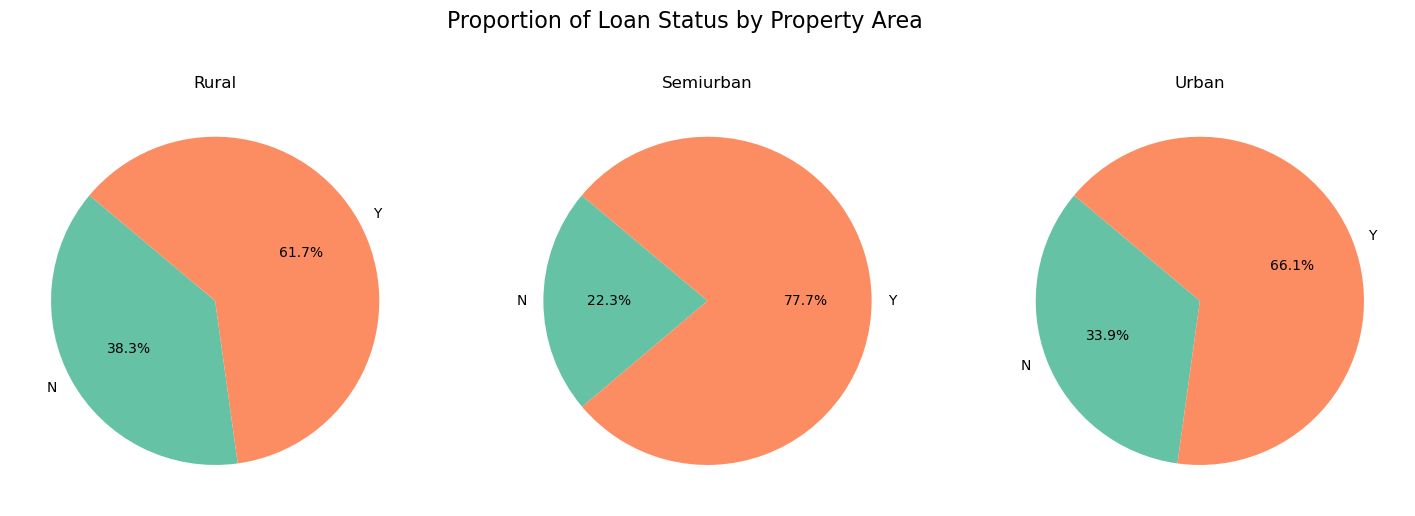

In [34]:
df_prop = df.groupby(['Property_Area', 'Loan_Status']).size().unstack().fillna(0)
df_prop = df_prop.div(df_prop.sum(axis=1), axis=0)  # Convert counts to proportions

# Plotting
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for i, property_area in enumerate(df_prop.index):
    ax = axes[i]
    proportions = df_prop.loc[property_area]
    ax.pie(proportions, labels=proportions.index, autopct='%1.1f%%', colors=sns.color_palette('Set2'), startangle=140)
    ax.set_title(property_area)

# Titles and labels
fig.suptitle('Proportion of Loan Status by Property Area', fontsize=16)
plt.show()

### Ml

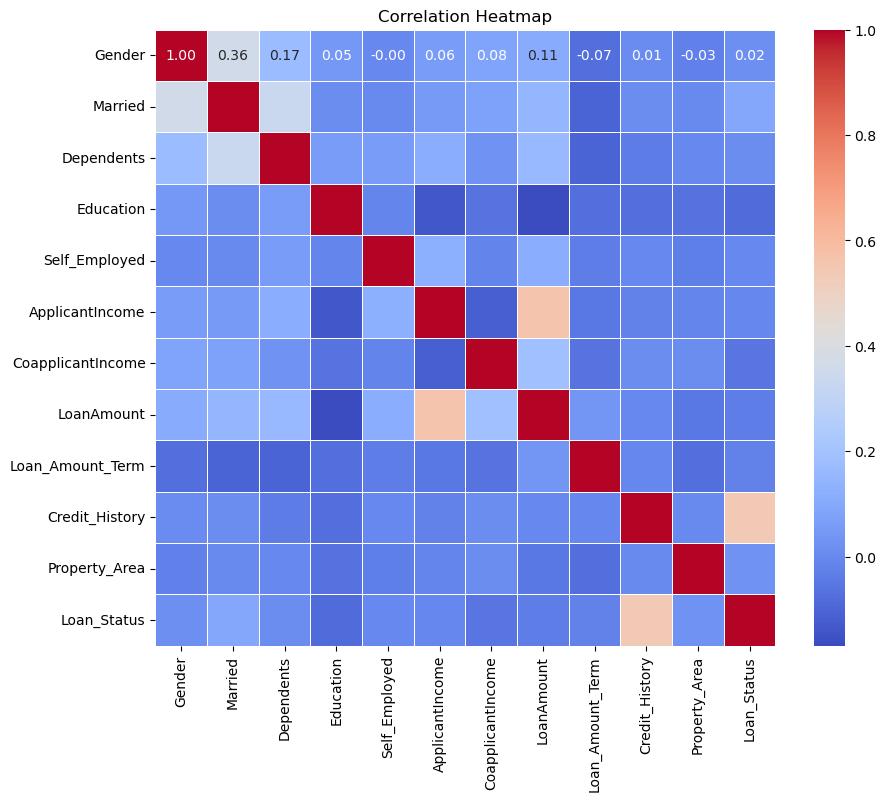

In [25]:
columns_to_analyze_3 = [
    'Gender', 'Married', 'Dependents', 'Education', 'Self_Employed',
    'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
    'Loan_Amount_Term', 'Credit_History', 'Property_Area', 'Loan_Status'
]
# Ensure all columns are in the DataFrame
df_filtered = df[columns_to_analyze_3]

# Convert categorical variables to numeric codes
df_filtered_encoded = df_filtered.copy()
for col in df_filtered_encoded.select_dtypes(include=['object']).columns:
    df_filtered_encoded[col] = df_filtered_encoded[col].astype('category').cat.codes

# Compute the correlation matrix
correlation_matrix = df_filtered_encoded.corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

Data Preparation and Training Loan Approval Prediction Model
In this step, we will:

convert categorical columns into numerical ones;
split the data into training and test sets;
scale the numerical features;
train the loan approval prediction model.

In [24]:
# Convert categorical columns to numerical using one-hot encoding
cat_cols = ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Property_Area']
df = pd.get_dummies(df, columns=cat_cols)

# Split the dataset into features (X) and target (y)
X = df.drop('Loan_Status', axis=1)
y = df['Loan_Status']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the numerical columns using StandardScaler
scaler = StandardScaler()
numerical_cols = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History']
X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])


model = SVC(random_state=42)
model.fit(X_train, y_train)

SVC(random_state=42)

In [25]:
y_pred = model.predict(X_test)
print(y_pred)

['Y' 'Y' 'Y' 'Y' 'Y' 'Y' 'Y' 'Y' 'Y' 'Y' 'Y' 'Y' 'Y' 'Y' 'N' 'Y' 'Y' 'Y'
 'Y' 'N' 'Y' 'Y' 'Y' 'Y' 'Y' 'N' 'Y' 'Y' 'Y' 'Y' 'Y' 'Y' 'N' 'Y' 'Y' 'Y'
 'Y' 'Y' 'Y' 'N' 'Y' 'Y' 'Y' 'Y' 'Y' 'Y' 'N' 'N' 'Y' 'Y' 'Y' 'Y' 'Y' 'Y'
 'Y' 'N' 'Y' 'Y' 'Y' 'N' 'Y' 'Y' 'Y' 'Y' 'Y' 'Y' 'Y' 'Y' 'Y' 'Y' 'Y' 'Y'
 'Y' 'Y' 'Y' 'N' 'Y' 'N' 'Y' 'Y' 'Y' 'N' 'Y' 'Y' 'Y' 'Y' 'N' 'Y' 'Y' 'Y'
 'Y' 'N' 'Y' 'Y' 'N' 'Y' 'Y' 'N' 'Y' 'Y' 'Y' 'Y' 'N' 'Y' 'Y' 'N' 'Y' 'Y'
 'Y' 'Y']


In [27]:
# Convert X_test to a DataFrame
X_test_df = pd.DataFrame(X_test, columns=X_test.columns)

# Add the predicted values to X_test_df
X_test_df['Loan_Status_Predicted'] = y_pred
X_test_df.head()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Gender_Female,Gender_Male,Married_No,Married_Yes,Dependents_0,...,Dependents_2,Dependents_3+,Education_Graduate,Education_Not Graduate,Self_Employed_No,Self_Employed_Yes,Property_Area_Rural,Property_Area_Semiurban,Property_Area_Urban,Loan_Status_Predicted
277,-0.544528,-0.037922,-0.983772,0.305159,0.402248,0,1,0,1,1,...,0,0,1,0,1,0,0,0,1,Y
84,-0.067325,-0.931554,-1.571353,-1.430680,0.402248,0,1,0,1,0,...,0,0,1,0,1,0,0,0,1,Y
275,-0.734870,0.334654,-0.298262,0.305159,0.402248,0,1,0,1,0,...,0,0,1,0,1,0,0,1,0,Y
392,-0.824919,0.522317,-0.200332,0.305159,0.402248,0,1,0,1,1,...,0,0,1,0,1,0,0,0,1,Y
537,-0.267373,-0.931554,-0.454950,0.305159,0.402248,0,1,1,0,0,...,1,0,1,0,1,0,0,1,0,Y
